In [2]:
import os

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from logistic_probability import MultiLogisticProbability

In [3]:
df = pd.read_csv('complete_df.csv', usecols= ['ticker', 'time', 'post title sentiment_score',
                                               'post body sentiment_score', 'comment sentiment_score',
                                               'Volume', 'Movement', 'Volume MA', 'Previous Movement'])

In [4]:
df.set_index(['ticker', 'time'], inplace=True)
X = df.loc[:, ~df.columns.str.contains('^Movement$')].iloc[1:] # for each ticker?
y = df.loc[:, 'Movement'].iloc[1:]

In [5]:
X

post title sentiment_score  post body sentiment_score  \
ticker time                                                                
AAPL   2025-06-10                   -0.256200                   0.487567   
       2025-06-11                    0.000000                   0.101167   
       2025-06-12                    0.128000                  -0.257600   
       2025-06-18                   -0.210750                  -0.338200   
       2025-06-20                    0.000000                   0.000000   
...                                       ...                        ...   
AMZN   2025-10-13                    0.100675                   0.312550   
       2025-10-14                    0.070433                   0.000000   
       2025-10-15                    0.000000                   0.102120   
       2025-10-16                   -0.165775                  -0.145550   
       2025-10-17                    0.009483                   0.000000   

                   comment sentiment_score    Volume   Volume MA  \
ticker time                                                        
AAPL   2025-06-10                 0.137300  54672600  49138300.0   
       2025-06-11                 0.328510  60989900  57831250.0   
       2025-06-12                 0.270236  43904600  52447250.0   
       2025-06-18                 0.202336  45394700  44649650.0   
       2025-06-20                 0.123950  96813500  71104100.0   
...                                    ...       ...         ...   
AMZN   2025-10-13                 0.311857  37809700  55088600.0   
       2025-10-14                 0.248811  45665600  41737650.0   
       2025-10-15                 0.091945  45909500  45787550.0   
       2025-10-16                 0.080631  42414600  44162050.0   
       2025-10-17                 0.054264  45986900  44200750.0   

                   Previous Movement  
ticker time                           
AAPL   2025-06-10                0.0  
       2025-06-11                1.0  
       2025-06-12                0.0  
       2025-06-18                1.0  
       2025-06-20                1.0  
...                              ...  
AMZN   2025-10-13                0.0  
       2025-10-14                1.0  
       2025-10-15                1.0  
       2025-10-16                0.0  
       2025-10-17                0.0  

[177 rows x 6 columns]

In [6]:
y

ticker  time      
AAPL    2025-06-10    1
        2025-06-11    0
        2025-06-12    1
        2025-06-18    1
        2025-06-20    1
                     ..
AMZN    2025-10-13    1
        2025-10-14    1
        2025-10-15    0
        2025-10-16    0
        2025-10-17    0
Name: Movement, Length: 177, dtype: int64

In [7]:
def backward_elimination(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    dependent_var = target.reset_index(drop=True)
    independent_vars = data.reset_index(drop=True)
    features = sm.add_constant(independent_vars)

    while len(features.columns) > 1:
        model = sm.GLM(dependent_var, features, family=sm.families.Binomial()).fit()
        max_p_value = max(model.pvalues)

        if max_p_value > significance_level:
            excluded_feature = model.pvalues.idxmax()
            features = features.drop(columns=[excluded_feature])
            print(f"Dropped {excluded_feature}: p-value {max_p_value}")
        else:
            break

    return features.columns.tolist(), model

# Perform backward elimination
final_features, final_model = backward_elimination(X, y)
print("Final set of features:", final_features)

Dropped Previous Movement: p-value 0.9144087815333681
Dropped post title sentiment_score: p-value 0.6352264801991152
Dropped post body sentiment_score: p-value 0.3817315787076443
Dropped const: p-value 0.21038227088188066
Dropped Volume MA: p-value 0.20587667737694826
Dropped Volume: p-value 0.5698610512386275
Final set of features: ['comment sentiment_score']


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

In [9]:
model = LogisticRegression()
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(model, X, y, cv=kfold, scoring="neg_log_loss")

In [10]:
scores.mean()

-0.6977133582704216

In [11]:
model_full = LogisticRegression()
model_full.fit(X, y)

LogisticRegression()

In [12]:
# instance = MultiLogisticProbability(model_full, model_full.predict(X), .50)

In [13]:
# instance.evaluate_confusion_matrix(y, model_full.predict(X), 'Movement', 0)

In [14]:
y = pd.DataFrame(y)

In [16]:
roc_curve(y, model_full.predict(X))

(array([0.        , 0.72619048, 1.        ]),
 array([0.        , 0.74193548, 1.        ]),
 array([inf,  1.,  0.]))

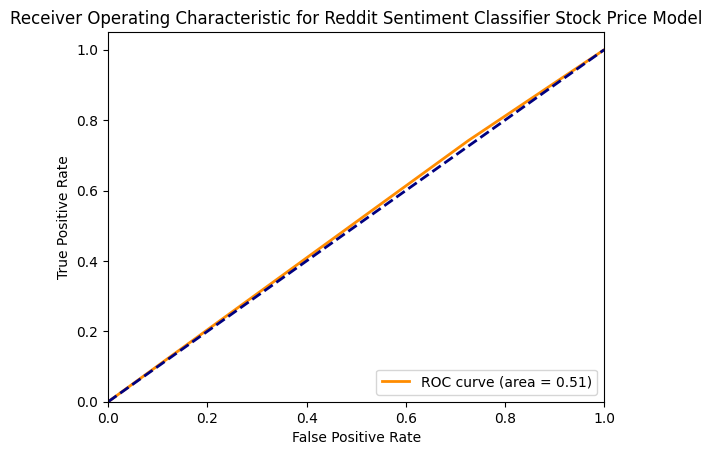

In [17]:
fpr, tpr, _ = roc_curve(y, model_full.predict(X))
roc_auc = auc(fpr, tpr)

# Step 5: Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Reddit Sentiment Classifier Stock Price Model')
plt.legend(loc="lower right")
plt.show()

In [18]:
features = sm.add_constant(X.reset_index(drop=True))
reduced_features = features.drop(columns=['post title sentiment_score', 'post body sentiment_score', 'comment sentiment_score'])
target = y.reset_index(drop=True)
# Fit the full logistic regression model
model_full = sm.GLM(target, features, family=sm.families.Binomial()).fit()
print(f"Full model summary:\n{model_full.summary()}\n")

# Fit the reduced logistic regression model
model_reduced = sm.GLM(target, reduced_features, family=sm.families.Binomial()).fit()
print(f"Reduced model summary:\n{model_reduced.summary()}\n")

Full model summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Movement   No. Observations:                  177
Model:                            GLM   Df Residuals:                      170
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -118.84
Date:                Sat, 25 Oct 2025   Deviance:                       237.68
Time:                        13:44:46   Pearson chi2:                     176.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04006
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [19]:
target

,Movement
0,1
1,0
2,1
3,1
4,1
...,...
172,1
173,1
174,0
175,0


In [20]:
# Calculate the deviance (2 * log-likelihood) for both models
deviance_full = -2 * model_full.llf
deviance_reduced = -2 * model_reduced.llf

# Calculate the chi-square test statistic
chi_square_stat = deviance_reduced - deviance_full

# Degrees of freedom is the difference in the number of parameters
df = len(model_full.params) - len(model_reduced.params)

# Calculate the p-value using the chi-square distribution
from scipy.stats import chi2
p_value = chi2.sf(chi_square_stat, df)

print(f"Chi-square statistic: {chi_square_stat}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_value}")

Chi-square statistic: 4.592390023121311
Degrees of freedom: 3
P-value: 0.2041958768323642


In [21]:
aapl_x = X.loc['AAPL', :]
aapl_y = y.loc['AAPL']
nvda_x = X.loc['NVDA', :]
nvda_y = y.loc['NVDA']
amzn_x = X.loc['AMZN', :]
amzn_y = y.loc['AMZN']
Xs = [aapl_x, nvda_x, amzn_x]
ys = [aapl_y, nvda_y, amzn_y]

In [22]:
for num, x in enumerate(Xs):
  model = LogisticRegression()
  model.fit(x, ys[num])
  predictions = model.predict(x)
  print(classification_report(ys[num], predictions))
  print(f'accuracy: {accuracy_score(ys[num], predictions)}')


              precision    recall  f1-score   support

           0       0.40      0.06      0.11        31
           1       0.54      0.92      0.68        37

    accuracy                           0.53        68
   macro avg       0.47      0.49      0.40        68
weighted avg       0.48      0.53      0.42        68

accuracy: 0.5294117647058824
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        32
           1       0.58      0.67      0.62        39

    accuracy                           0.55        71
   macro avg       0.54      0.54      0.53        71
weighted avg       0.54      0.55      0.54        71

accuracy: 0.5492957746478874
              precision    recall  f1-score   support

           0       0.60      0.86      0.71        21
           1       0.62      0.29      0.40        17

    accuracy                           0.61        38
   macro avg       0.61      0.58      0.55        38
weighted avg    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
